# Accessing GEDI L4A Dataset with NASA OPeNDAP in the Cloud
The Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) is available from NASA OPeNDAP Hyrax. This tutorial will demonstrate how to directly access and subset the GEDI L4A dataset using OPeNDAP Hyrax. Hyrax allows direct access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data files.

We will use NASA's Earthdata Common Metadata Repository (CMR) Application Programming Interface (API) to search for GEDI L4A granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Please also refer to this tutorial for additional details on performing a spatio-temporal search for GEDI L4A granules.

This tutorial requires the following Python modules installed in your system: requests, numpy, netCDF4, datetime, pandas, geopandas, contextily, shapely, pydap, seaborn. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

### pip install -r requirements.txt

In [2]:
# import modules
%matplotlib inline
import os
from os import path
from glob import glob
import requests
import datetime as dt 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import netCDF4 as nc
from matplotlib import pyplot as plt
from pydap.cas.urs import setup_session
from shapely.ops import orient
from IPython import display
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Creating the path to the GEDI data
ROOT_PATH = os.path.join("E:\GEDI_biomass")
# Creating the path to the GEDI data
indir = os.path.join(ROOT_PATH, "data","raw")
os.listdir(indir)

['GEDI4A', 'GEDI_gridded', 'polygons']

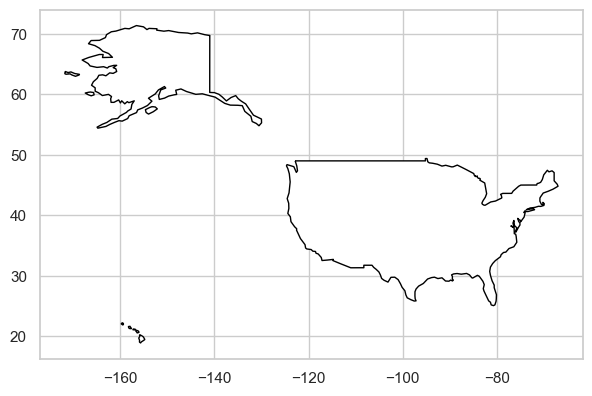

In [7]:
aca = gpd.read_file(os.path.join(indir,"polygons","mtbs_2_fires.GEOJSON")) 
aca.crs = "EPSG:4326"
aca.geometry = aca.geometry.apply(orient, args=(1,))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world[world.name == 'United States of America'].plot(color='white', edgecolor='black', figsize  = (7, 7))
ax= aca.plot(ax=base, color='red')

In this example, we will search for all the GEDI L4A files available for the area using the CMR API.You can limit the years of interests using start and end time below.

In [5]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 
doisearch = f"{cmrurl}collections.json?doi={doi}"
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

# defining geojson
geojson = {"shapefile": (os.path.join(indir,"polygons","Selected_fires_b.GEOJSON"), aca.geometry.to_json(), "application/geo+json")}
page_num = 1
page_size = 2000 # CMR page size limit

# time bound for 2020
start_date = dt.datetime(2022, 1, 1) # specify your own start date
end_date = dt.datetime(2022, 12, 31)  # specify your end start date

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

opendap_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "temporal": temporal_str,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = f"{cmrurl}granules.json"
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()['feed']['entry']
    if granules:
        for g in granules:          
            # Get OPeNDAP URLs
            for links in g['links']:
                if 'title' in links and links['title'].startswith('OPeNDAP'):
                    opendap_url = links['href']
                    opendap_arr.append(opendap_url)
        page_num += 1
    else: 
        break

total_granules = len(opendap_arr)
print ("Total granules found: ", total_granules)

Total granules found:  25


We have stored the GEDI L4A OPeNDAP URLs into a Python list granule_arr. Let's print the first three granules from the list.

# 2. Access the variables of interest for the subset area via OPeNDAP
Access to NASA OPeNDAP requires NASA Earthdata authentication. Please set up a new account if you do not already have a NASA Earthdata account. We will use Python's pydap module to set up the authentication.

In [14]:
# Setting up the Earthdata URS Login session. 
# Get account here https://urs.earthdata.nasa.gov/
# Replace username and password with your credentials

username = "username"
password= "Passowrd**"
session = setup_session(username, password, check_url="https://opendap.earthdata.nasa.gov/")

OPeNDAP allows access to the dataset of interest, so you can only download the variables you are interested in and, by doing so, save the download bandwidth. We are interested in the following selected science variables for all the eight GEDI beams for this tutorial.

In [15]:
# variables of interests
variables = ['agbd', 'l4_quality_flag', 'land_cover_data/pft_class']

# beams of interest
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

We will save the data retrieved from OPeNDAP into the following CSV file.

In [10]:
# output CSV file
out_csv = os.path.join(indir,"GEDI4A","select_fires2.csv")

# setting header variables
headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
headers.extend(variables)

with open(out_csv, "w") as f:
    f.write(','.join(headers)+'\n')

Now, we will retrieve the dataset from the OPeNDAP Hyrax server. We will use the following approach to access the dataset. First, we will access the geographic variables (lat_lowestmode, lon_lowestmode) of all the GEDI shots within the beam to identify the shots overlapping the area of interest. We will then retrieve the science variables of interest (agbd, agbd_t, etc.) for the area of interest and save it as the CSV file we created above.

The following step will take time to run. The figure below will update to indicate the files being downloaded.

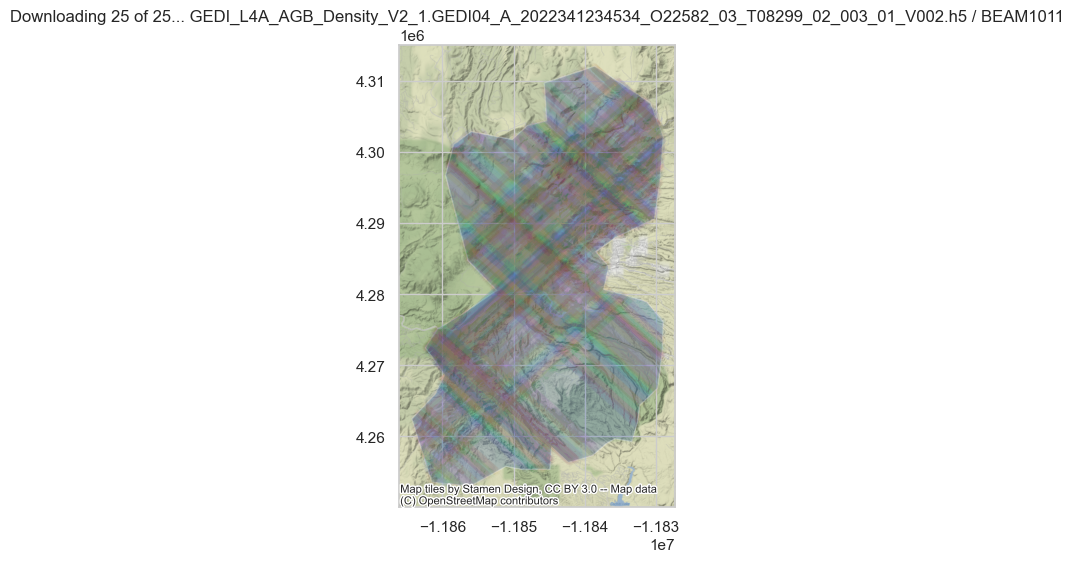

In [16]:
# setting up maximum retries to get around Hyrax 500 error
retries = Retry(total=15, backoff_factor=0.1, status_forcelist=[ 500, 502, 503, 504 ])
session.mount('https://', HTTPAdapter(max_retries=retries))

# plotting the area of interest
ax=aca.to_crs(epsg=3857).plot(figsize=(5, 6), alpha=0.3)
ctx.add_basemap(ax)
ax.set_title("Starting download...")
display.display(plt.gcf())
display.clear_output(wait=True)

c=0
for g_name in opendap_arr:
    c += 1
    # loop over all beams
    for beam in beams:       
        # 1. Retrieving lat, lon coordinates for the file
        hyrax_url = f"{g_name}.dap.nc4?dap4.ce=/{beam}/lon_lowestmode;/{beam}/lat_lowestmode"
        r = session.get(hyrax_url)
        if (r.status_code != 400):
            ds = nc.Dataset('hyrax', memory=r.content)
            lat = ds[beam]['lat_lowestmode'][:]
            lon = ds[beam]['lon_lowestmode'][:]
            ds.close()
            df = pd.DataFrame({'lat_lowestmode': lat, 'lon_lowestmode': lon}) # creating pandas dataframe  

            # 2. Subsetting by bounds of the area of interest
            # converting to geopandas dataframe
            gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode)) 
            gdf_aca = gdf[gdf['geometry'].within(aca.geometry[0])]   
            if not gdf_aca.empty:
                # creating empty columns for variables
                for v in headers[2:]:
                    gdf_aca[v] = None
                # 3. retrieving variables of interest, agbd, agbd_t in this case.
                # We are only retriving the shots within subset area.
                for _, df_gr in gdf_aca.groupby((gdf_aca.index.to_series().diff() > 1).cumsum()):
                    i = df_gr.index.min()
                    j = df_gr.index.max()
                    for v in headers[2:]:
                        var_s = f"/{beam}/{v}%5B{i}:{j}%5D"
                        hyrax_url = f"{g_name}.dap.nc4?dap4.ce={var_s}"
                        r = session.get(hyrax_url)
                        if (r.status_code != 400):
                            ds = nc.Dataset('hyrax', memory=r.content)
                            gdf_aca.loc[i:j, (v)] = ds[beam][v][:]
                            ds.close()

                # saving the output file
                gdf_aca.to_csv(out_csv, mode='a', index=False, header=False, columns=headers)

                # plotting the shots
                gdf_aca.crs = "EPSG:4326"
                gdf_aca.to_crs(epsg=3857).plot(alpha=0.01, ax=ax, linewidth=0)
                ax.set_title(f"Downloading {c} of {total_granules}... {g_name.rsplit('/', 1)[-1]} / {beam}")
                display.display(plt.gcf())
                display.clear_output(wait=True)

In [17]:
# reading the csv file created in the last step
l4a_df = pd.read_csv(out_csv)
l4a_df.head()

,lat_lowestmode,lon_lowestmode,elev_lowestmode,shot_number,agbd,l4_quality_flag,land_cover_data/pft_class
0,35.692223,-106.567238,2476.003418,117070000300270728,57.823112,0,6
1,35.691877,-106.566773,2463.384521,117070000300270729,6.552126,0,6
2,35.691532,-106.566307,2433.746094,117070000300270730,88.443230,0,6
3,35.691187,-106.565841,2404.368652,117070000300270731,13.573183,0,6
4,35.690841,-106.565375,2386.414795,117070000300270732,12.696663,0,6


We can now plot the distribution of the AGBD by plant functional types (PFTs) for the good quality shots in the ACA region.

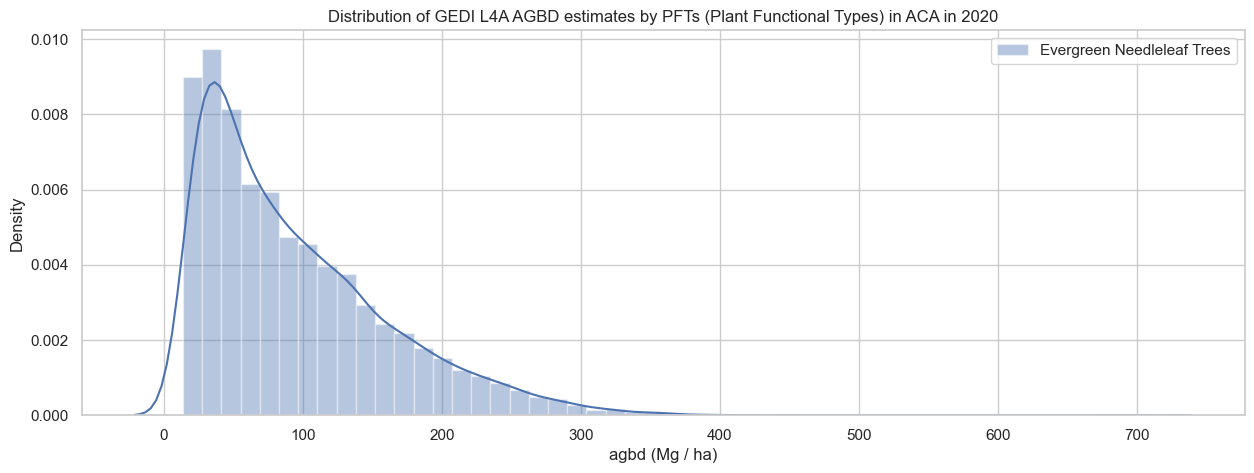

<Figure size 640x480 with 0 Axes>

In [24]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 1: 'Evergreen Needleleaf Trees', 2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  4: 'Deciduous Broadleaf Trees', 5: 'Shrub', 6: 'Grass',
              7: 'Cereal Croplands', 8: 'Broadleaf Croplands', 9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 11: 'Barren', 255: 'Unclassified'}

# creating mask with good quality shots and trees/shrubs pft class
mask = (l4a_df['l4_quality_flag']==1) & (l4a_df['land_cover_data/pft_class'] <= 5 ) 
plt.figure(figsize=(15,5))
ax = l4a_df[mask].groupby('land_cover_data/pft_class')['agbd'].\
            apply(lambda x: sns.distplot(x, label = pft_legend[x.name], hist=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs (Plant Functional Types) in ACA in 2020')
plt.legend()
plt.show()
plt.savefig("test.png")

Let's also plot how the AGBD is distributed across elevation ranges for different PFTs.

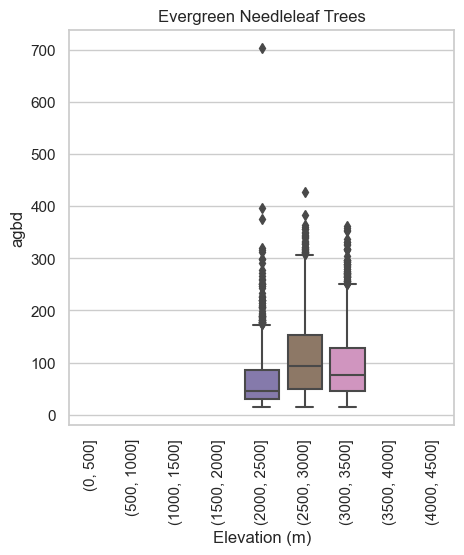

In [23]:
l4a_df['elev_bin']=pd.cut(l4a_df['elev_lowestmode'], bins =range(0, 5000, 500))
g = sns.catplot(x = "elev_bin", y = "agbd", data = l4a_df[mask], col="land_cover_data/pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.savefig("agbd_category.png")

Hyrax in its current form has some limitations. It does not support the subsetting of a string array, so GEDI L4A variables such as predict_stratum can not be accessed using the approach described above.